In [1]:
import os
#os.chdir('/workspace/FutureGPT2/src/')
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'

from datasets import load_dataset
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from itertools import islice
from collections import defaultdict
import re
from tqdm import tqdm
import torch
from torch import nn
import numpy as np
import gc
from matplotlib import pyplot as plt
import datasets
from torch.utils.data import DataLoader
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.get_device_capability()[0] >= 8:
    torch.set_float32_matmul_precision('high')

In [3]:
pythia_sizes = [
    ('14m', 1.4e7), 
    ('70m', 7.0e7), 
    ('160m', 1.6e8), 
    ('410m', 4.1e8), 
    ('1b', 1.0e9), 
    ('1.4b', 1.4e9), 
    ('2.8b', 2.8e9), 
    ('6.9b', 6.9e9), 
    ('12b', 1.2e10),
][::-1]

In [5]:
owt = load_dataset('openwebtext', split='train[:50]')
owt_loader = DataLoader(owt, batch_size=1)

In [6]:
beams = [1, 2, 3, 5, 10][::-1]

In [7]:
torch.set_grad_enabled(False)
gc.collect()
torch.cuda.empty_cache()

In [9]:
loss_d = defaultdict(lambda: defaultdict(lambda: 0))
for size, _ in pythia_sizes[1:]:
    print(size)
    model_name = f'EleutherAI/pythia-{size}'
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        #force_download=True,
        #resume_download=True,
    ).to('cuda')
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    total = 0
    for batch in tqdm(iter(owt_loader)):
        input = tokenizer(
            **batch, 
            max_length=64, 
            truncation=True, 
            return_tensors='pt',
        ).to('cuda')
        for beam in beams:
            gc.collect()
            torch.cuda.empty_cache()
            out = model.generate(
                **input,
                max_new_tokens=128,
                min_new_tokens=128,
                num_beams=beam,
                num_return_sequences=beam,
                return_dict_in_generate=True, 
                output_scores=True,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False,
                length_penalty=0.,
            )
            if beam > 1:
                score = model.compute_transition_scores(
                    out.sequences, out.scores, out.beam_indices,
                )
                loss_d[size][beam] += score[0].mean() # 0th sequence is best, probably?
            else:
                score = model.compute_transition_scores(
                    out.sequences, out.scores, normalize_logits=True,
                )
                loss_d[size][beam] += score.mean() # 0th sequence is best, probably?
        total += 1
    for b in loss_d[size]:
        loss_d[size][b] /= total

6.9b


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/42.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.91G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [17:56<00:00, 21.54s/it]


2.8b


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [16:15<00:00, 19.51s/it]


1.4b


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [12:32<00:00, 15.06s/it]


1b


config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [08:59<00:00, 10.80s/it]


410m


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/911M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [12:25<00:00, 14.91s/it]

160m


config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [06:44<00:00,  8.08s/it]


70m


config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [03:58<00:00,  4.77s/it]


14m


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 50/50 [03:40<00:00,  4.42s/it]


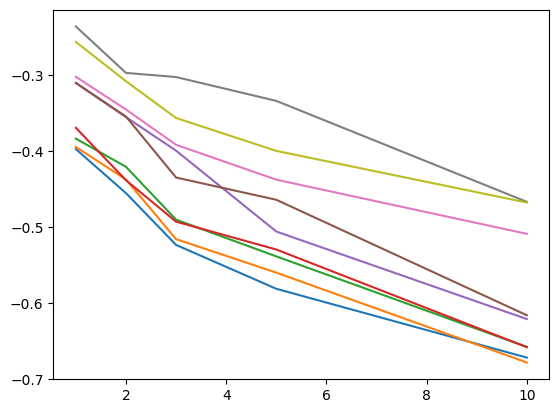

In [13]:
for size in loss_d:
    plt.plot([1, 2, 3, 5, 10], [x.item() for x in loss_d[size].values()])
plt.show()

In [15]:
for size in loss_d:
    print(size, (loss_d[size][10] - loss_d[size][1]).item())

12b 0.27451905608177185
6.9b 0.2837967276573181
2.8b 0.2742305099964142
1.4b 0.2887533903121948
1b 0.31075820326805115
410m 0.3059289753437042
160m 0.20680078864097595
70m 0.23086319863796234
14m 0.2114497721195221
